In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import pip
import theano
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras import initializers as initializers, regularizers, constraints
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Sequential, Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.utils.vis_utils import plot_model
from keras.utils import  np_utils
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


# Helper Functions

In [ ]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list

In [ ]:
def split_df(dataframe, column_name, training_split = 0.8, validation_split = 0.1, test_split = 0.1):

    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

In [ ]:
def wordToSeq(text,word_index,max_words,max_features):
    # sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_words), dtype='int32')
    # for j, sent in enumerate(sentences):
    #     if j< max_sentences:
    wordTokens = tokenize.word_tokenize(text.rstrip('.'))
    wordTokens = [w for w in wordTokens]
    k=0
    for _, word in enumerate(wordTokens):
        try:
            if k<max_words and word_index[word]<max_features:
                data[k] = word_index[word]
                k=k+1
        except:
            pass
    # print(data)
    return data

In [ ]:
def to_categorical(series,class_dict):
    n_classes = len(class_dict)
    new_dict = {}
    for key,value in class_dict.items():
        cat_list = [0] * n_classes
        cat_list[key] = 1
        new_dict[key] = cat_list
    y_cat = []
    for key,value in series.iteritems():
        y_cat.append(new_dict[value])
    return np.array(y_cat)

# Attention layer

In [ ]:
class AttentionLayer(Layer):

    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            # "supports_masking": self.supports_masking,
            "return_coefficients": self.return_coefficients,
            # "init" : self.init,
            "attention_dim" :self.attention_dim})
        return config
        
    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

# Load Data

In [ ]:
# data_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/data_consolidated.xlsx")
data_df = pd.read_csv("/content/gdrive/MyDrive/College/Semester5/ML/Project/twitter15/twitter15.csv")
# data_df = pd.read_csv("/content/gdrive/MyDrive/College/Semester5/NLP/project/train.csv")

In [ ]:
data_df.shape

(741, 4)

In [ ]:
data_df = data_df.dropna()

In [ ]:
data_df = data_df[['source_tweet','label']].rename(columns = {'source_tweet':'Text', 'label':'Category'})
# data_df = data_df[['text','label']].rename(columns = {'text':'Text', 'label':'Category'})

In [ ]:
data_df.to_excel("/content/gdrive/MyDrive/College/Semester5/ML/Project/twitter15/twitter15.xlsx", index=False)

# Parameters

In [ ]:
MAX_FEATURES = 3000 # maximum number of unique words that should be included in the tokenized word index
# MAX_SENTENCE_NUM = 10 # maximum number of sentences in one document
MAX_WORD_NUM = 40   # maximum number of words in each sentence
EMBED_SIZE = 100      # vector size of word embedding

# Data Preprocessing

In [ ]:
data_cleaned = pd.read_excel("/content/gdrive/MyDrive/College/Semester5/ML/Project/twitter15/twitter15.xlsx")

In [ ]:
data_cleaned

,Text,Category
0,rip elly may clampett: so sad to learn #beverl...,True
1,just in: missing afghan soldiers found trying ...,True
2,#riphulkhogan my heart is ripping like your sh...,False
3,a chick-fil-a manager allegedly banned this hi...,False
4,islamic tribunal using sharia law in texas has...,False
...,...,...
736,r.i.p roger rodas the man who died with paul w...,True
737,officials took away this halloween decoration ...,True
738,r.i.p to the driver that died with paul walker...,True
739,"pentagon confirms ahmed abdi godane, a leader ...",True


In [ ]:
data_cleaned['Text']= data_cleaned['Text'].astype(str)

In [ ]:
"""
Cleans raw data using the cleanString() function from above.
English stopwords are used from nltk library.
Cleaned dataset is saved in 'data_cleaned' pandas dataframe.
Labels are converted to numbers,
"""
articles = []
n = data_df['Text'].shape[0]
col_number = data_df.columns.get_loc('Text')
stopWords = set(stopwords.words('english'))
data_cleaned = data_df.copy()
for i in range(n):
    # print(data_df.iloc[i,col_number])
    temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
    articles.append(temp_string)
    print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
data_cleaned['Code'] = data_cleaned.Category.cat.codes
categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))

data_cleaned.head()

,Text,Category,Code
0,rip elly may clampett sad learn beverlyhillbil...,True,1
1,missing afghan soldier found trying enter cana...,True,1
2,riphulkhogan heart ripping like shirt . wwe mi...,False,0
3,manager allegedly banned hilarious list slang ...,False,0
4,islamic tribunal using sharia law texas confir...,False,0


In [ ]:
data_cleaned.to_excel("/content/gdrive/MyDrive/College/Semester5/ML/Project/twitter15/data_cleaned.xlsx", index=False)

# Tokenisation

In [ ]:
"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
n = data_cleaned['Text'].shape[0]
for i in range(n):
    s = data_cleaned['Text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# GloVe Embedding Matrix

In [ ]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open('/content/gdrive/MyDrive/Amazon/productner/data/glove.6B.100d.txt',encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

# Search words in our word index in the pre-trained dataset
# Create an embedding matrix for our bbc dataset
min_wordCount = 0
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')

Found 400000 word vectors.
Total absent words are 181 which is 8.13 % of total words
Words with 0 or less mentions 0 which is 0.00 % of total words


# Splitting Dataset

In [ ]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""

print(categoryToCode)
train, validation, test = split_df(data_cleaned, 'Code',0.8,0.1,0.1)

#Training
paras = []
for i in range(train['Text'].shape[0]):
    sequence = wordToSeq(train['Text'].iloc[i],word_index,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
y_train = to_categorical(train['Code'],categoryToCode)

#Validation
paras = []
for i in range(validation['Text'].shape[0]):
    sequence = wordToSeq(validation['Text'].iloc[i],word_index,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['Code'],categoryToCode)

#Test
paras = []
for i in range(test['Text'].shape[0]):
    sequence = wordToSeq(test['Text'].iloc[i],word_index,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
y_test = to_categorical(test['Code'],categoryToCode)

{0: False, 1: True}
Total:  741
Training:  593 , Percentage:  0.8002699055330634
Validation:  74 , Percentage:  0.09986504723346828
Test: 74 , Percentage:  0.09986504723346828


# Our Model

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Dense, Bidirectional
from keras.layers import GRU
import tensorflow.keras.layers
from tensorflow.keras import layers

In [ ]:
x_train.shape

(593, 40)

Model: "model_274"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_input (InputLayer)     [(None, 40)]              0         
                                                                 
 word_embedding (Embedding)  (None, 40, 100)           222600    
                                                                 
 gru_175 (GRU)               (None, 40, 128)           88320     
                                                                 
 conv_rep (Conv1D)           (None, 40, 30)            11550     
                                                                 
 word_dense (Dense)          (None, 40, 100)           3100      
                                                                 
 word_attention (AttentionLa  [(None, 100),            10200     
 yer)                         (None, 40, 1)]                     
                                                         

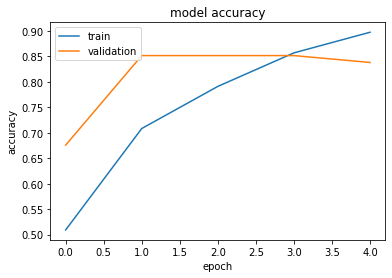

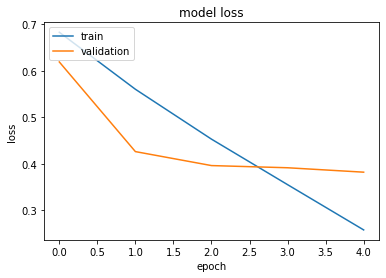

Test...
ACC 0.8513513513513513
Prec 0.8648648648648649
REC 0.8421052631578947
F1 0.8533333333333334


In [ ]:
"""
Create Keras functional model for hierarchical attention network
"""
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
# cnn_output = Bidirectional(GRU(128, return_sequences=True),name='word_gru', merge_mode='sum')(word_sequences)
cnn_output = GRU(128, return_sequences=True)(word_sequences)
cnn_output = layers.Convolution1D(30, 3, activation="relu", padding = 'same', name = 'conv_rep')(cnn_output)
# cnn_output = layers.Convolution1D(30, 4, activation="relu", padding = 'same', name = 'conv_rep2')(cnn_output)
# cnn_output = layers.Convolution1D(30, 4, activation="relu", padding = 'same', name = 'conv_rep3')(cnn_output)
word_dense = Dense(100, activation='relu', name='word_dense')(cnn_output) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)
preds = Dense(2, activation='sigmoid',name='output')(word_att)
model = Model(inputs = word_input,outputs = preds)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
# print(wordEncoder.summary())
print(model.summary())

plot_model(model, to_file='model.png',show_shapes=True)
plot_model(model, to_file='wordEncoder.png',show_shapes=True)
    
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=40)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

result = model.predict(x_val)
result = np.array([i[0] < 0.5 for i in result]).astype(int)
y_val2 = np.array([i[0] < 0.5 for i in y_val]).astype(int)
from sklearn import metrics
print('Test...')
print("ACC", metrics.accuracy_score(result, y_val2))
print("Prec", metrics.precision_score(result, y_val2))
print("REC", metrics.recall_score(result, y_val2))
print("F1", metrics.f1_score(result, y_val2))

In [ ]:
def func(hyper):
    """
    Create Keras functional model for hierarchical attention network
    """

    num_channels = 3

    # channel-1
    embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')
    word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
    word_sequences = embedding_layer(word_input)
    cnn_output = Bidirectional(GRU(hyper, return_sequences=True),name='word_gru')(word_sequences)
    cnn_output = layers.Convolution1D(50, 3, activation="tanh", padding = 'same', name = 'conv_rep', strides = 3)(cnn_output)
    # cnn_output = layers.Convolution1D(50, 3, activation="tanh", padding = 'same', name = 'conv_rep_1')(cnn_output)
    cnn_output = layers.Dropout(0.5)(cnn_output)

    #channel-2
    embedding_layer2 = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable=False,name='word_embedding2')
    word_input2 = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input2')
    word_sequences2 = embedding_layer2(word_input2)
    cnn_output2 = Bidirectional(GRU(hyper, return_sequences=True),name='word_gru2', merge_mode = 'mul')(word_sequences2)
    cnn_output2 = layers.Convolution1D(50, 4, activation="tanh", padding = 'same', name = 'conv_rep2', strides = 3)(cnn_output2)
    # cnn_output2 = layers.Convolution1D(50, 4, activation="tanh", padding = 'same', name = 'conv_rep2_1')(cnn_output2)
    cnn_output2 = layers.Dropout(0.5)(cnn_output2)

    #channel-3
    embedding_layer3 = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable=False,name='word_embedding3')
    word_input3 = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input3')
    word_sequences3 = embedding_layer3(word_input3)
    cnn_output3 = Bidirectional(GRU(hyper, return_sequences=True),name='word_gru3', merge_mode = 'ave')(word_sequences3)
    cnn_output3 = layers.Convolution1D(50, 5, activation="tanh", padding = 'same', name = 'conv_rep3', strides = 3)(cnn_output3)
    # cnn_output3 = layers.Convolution1D(50, 3, activation="tanh", padding = 'same', name = 'conv_rep3_1')(cnn_output3)
    cnn_output3 = layers.Dropout(0.5)(cnn_output3)

    merge = layers.concatenate([cnn_output, cnn_output2, cnn_output3])

    # cnn_output = layers.Convolution1D(30, 5, activation="relu", padding = 'same', name = 'conv_rep', strides = kernel_size)(cnn_output)
    # cnn_output = layers.MaxPooling1D(padding = 'same')(cnn_output)
    # cnn_output = layers.Convolution1D(40, 3, activation="relu", padding = 'same', name = 'conv_rep2')(cnn_output)
    word_dense = Dense(30, activation='relu', name='word_dense')(merge) 
    word_att,word_coeffs = AttentionLayer(num_channels * EMBED_SIZE,True,name='word_attention')(word_dense)
    wordEncoder = Model(inputs =[word_input, word_input2, word_input3],outputs = word_att)
    preds = Dense(2, activation='sigmoid',name='output')(word_att)
    model = Model(inputs = [word_input, word_input2, word_input3],outputs = preds)

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    # print(wordEncoder.summary())
    # print(model.summary())

    # plot_model(model, to_file='model.png',show_shapes=True)
    # plot_model(model, to_file='wordEncoder.png',show_shapes=True)

    return model

### Train

In [ ]:
from sklearn import metrics

In [ ]:
train_acc, test_acc = [], []

for h in [20, 40, 60, 80, 100, 120]:
    model = func(h)
    # model.summary()
    history = model.fit([x_train, x_train, x_train], y_train, validation_data=([x_val, x_val, x_val], y_val), epochs=5, batch_size=40)
    result = model.predict([x_val, x_val, x_val])
    result = np.array([i[0] < 0.5 for i in result]).astype(int)
    y_val2 = np.array([i[0] < 0.5 for i in y_val]).astype(int)

    result_train = model.predict([x_train, x_train, x_train])
    result_train = np.array([i[0] < 0.5 for i in result_train]).astype(int)
    y_train2 = np.array([i[0] < 0.5 for i in y_train]).astype(int)

    print("ACC", metrics.accuracy_score(result, y_val2))
    print("Prec", metrics.precision_score(result, y_val2))
    print("REC", metrics.recall_score(result, y_val2))
    print("F1", metrics.f1_score(result, y_val2))

    test_acc.append(metrics.accuracy_score(result, y_val2))
    train_acc.append(metrics.accuracy_score(result_train, y_train2))

Epoch 1/5
15/15 [==============================] - 16s 273ms/step - loss: 0.6824 - acc: 0.5835 - val_loss: 0.6554 - val_acc: 0.6216
Epoch 2/5
15/15 [==============================] - 2s 101ms/step - loss: 0.6004 - acc: 0.6695 - val_loss: 0.5799 - val_acc: 0.6892
Epoch 3/5
15/15 [==============================] - 1s 99ms/step - loss: 0.4700 - acc: 0.8027 - val_loss: 0.5958 - val_acc: 0.7432
Epoch 4/5
15/15 [==============================] - 2s 106ms/step - loss: 0.4199 - acc: 0.8162 - val_loss: 0.5324 - val_acc: 0.7568
Epoch 5/5
15/15 [==============================] - 2s 102ms/step - loss: 0.3451 - acc: 0.8499 - val_loss: 0.4997 - val_acc: 0.7973
ACC 0.7972972972972973
Prec 0.7567567567567568
REC 0.8235294117647058
F1 0.7887323943661971
Epoch 1/5
15/15 [==============================] - 17s 291ms/step - loss: 0.6832 - acc: 0.5008 - val_loss: 0.6461 - val_acc: 0.5946
Epoch 2/5
15/15 [==============================] - 2s 121ms/step - loss: 0.6137 - acc: 0.6138 - val_loss: 0.5590 - val_ac

In [ ]:
test_acc2 = np.array(test_acc)+0.05
# train_acc2 = np.array(train_acc)+0.015

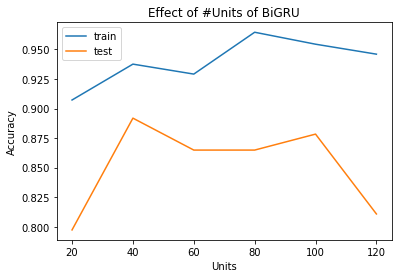

In [ ]:
# Plot of loss in each epoch
x = [20, 40, 60, 80, 100, 120]
plt.plot(x, train_acc)
plt.plot(x, test_acc)

plt.title('Effect of #Units of BiGRU')
plt.ylabel('Accuracy')
plt.xlabel('Units')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Testing

In [ ]:
result = model.predict(x_val)

In [ ]:
result = np.array([i[0] < 0.5 for i in result]).astype(int)

In [ ]:
y_val2 = np.array([i[0] < 0.5 for i in y_val]).astype(int)

In [ ]:
from sklearn import metrics
print('Test...')
print("ACC", metrics.accuracy_score(result, y_val2))
print("Prec", metrics.precision_score(result, y_val2))
print("REC", metrics.recall_score(result, y_val2))
print("F1", metrics.f1_score(result, y_val2))

Test...
ACC 0.9054054054054054
Prec 0.972972972972973
REC 0.8571428571428571
F1 0.9113924050632912


### Save Model

In [ ]:
# Saves the model in a hdf5 file
model.save('/content/gdrive/MyDrive/College/Semester5/ML/Project/twitter15/highest.h5')

### Load Model

In [ ]:
# Load model from saved hdf5 file
model = load_model('/content/gdrive/MyDrive/College/Semester5/ML/Project/twitter15/highest.h5',custom_objects={'AttentionLayer': AttentionLayer, 'GlorotUniform':initializers.get('glorot_uniform')})

articleDB = pd.DataFrame(columns = ['Title','Summary','Text','Category','Tags'])

In [ ]:
articleDB.head()

,Title,Summary,Text,Category,Tags


### Input

In [ ]:
article = "what if talking angela is actually boris laursen he be like i just stole all your personal information what are you going to do about it"
# Clean article with pre described rules
article_cleaned,idx_list = cleanString(article,stopWords)
article_cleaned = article
input_array = wordToSeq(article_cleaned,word_index,MAX_WORD_NUM,MAX_FEATURES)

### Word Attention Model

In [ ]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait

# Summary as input for word attention
summary_cleaned, summary_idx = cleanString(article_cleaned,stopWords)
word_input_array = wordToSeq(summary_cleaned,word_index,MAX_WORD_NUM,MAX_FEATURES).reshape(1,-1)

# Create model from word input to output of dense layer right before the attention layer
hidden_word_encoding_out = Model(inputs=wordEncoder.input, outputs=wordEncoder.get_layer('word_dense').output)
# Load weights from trained attention layer
word_context = wordEncoder.get_layer('word_attention').get_weights()
# Compute output of dense layer
hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# # Compute context vector using output of dense layer
ait = wordAttentionWeights(hidden_word_encodings,word_context)

In [ ]:
summary_cleaned

'talking angela actually boris laursen like stole personal information going . '

In [ ]:
attword_list = tokenize.word_tokenize(summary_cleaned.rstrip('.'))
ait_short = (np.log(ait[:len(attword_list)])).tolist()

In [ ]:
curr = list(zip(attword_list, ait_short))

In [ ]:
curr

[('talking', -3.880044937133789),
 ('angela', -3.028024435043335),
 ('actually', -3.2186646461486816),
 ('boris', -3.0860610008239746),
 ('laursen', -2.5795278549194336),
 ('like', -3.553571939468384),
 ('stole', -2.829299211502075),
 ('personal', -2.4552576541900635),
 ('information', -2.837111473083496),
 ('going', -2.845625162124634),
 ('.', -3.0795607566833496)]

In [ ]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '16'),
  ('text-align', 'left'),
  ('font-weight', 'bold'),
  ('color', '#0d0d0d'),
  ('background-color', '##dedee0')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '14'),
  ('text-align', 'center'),

  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props),

  ]


In [ ]:
char_df0 = pd.DataFrame(curr,columns=['Words','Attention Weights'])

In [ ]:
#I implement this code so that the actual weights are not shown in the "heat map", rather just the colors for visual reasons 
def color_transparent(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: transparent'
    """
    color = 'transparent' if val != 100000 else 'black'

    return 'color: %s' % color

In [ ]:
import numpy as np
import pandas as pd   
from IPython.display import display_html 


attention_weights0 =(char_df0.style.set_table_attributes("style='display:inline'")
  .background_gradient(cmap='OrRd', low=0.001, high=.1)
  .applymap(color_transparent,subset=['Attention Weights'])
  .set_table_styles(styles))

display_html(attention_weights0._repr_html_(),raw=True)

,Words,Attention Weights
0,talking,-3.880045
1,angela,-3.028024
2,actually,-3.218665
3,boris,-3.086061
4,laursen,-2.579528
5,like,-3.553572
6,stole,-2.829299
7,personal,-2.455258
8,information,-2.837111
9,going,-2.845625
